In [1]:
def find_project_path(matker:str = '.git') -> str:
    from pathlib import Path
    if '__file__' in globals():
        current_path = Path(__file__).resolve()
    else:
        current_path = Path().resolve()
    project_root = current_path
    while not (project_root / matker).exists():
        project_root = project_root.parent
        if project_root == project_root.parent:
            raise ValueError("Reached the root of the file system without finding the marker.")
    return str(project_root)

prj_path = find_project_path()
print(f"{prj_path = }")
import sys
sys.path.insert(0, prj_path)


from ccsmodel import CCSSim, ccs_plant
import tj010
from tj010.tj007pyInterface import ControllerInterface, OutputVariable, InputVariable
import tj010.mpcplot as mpcplot
print(f'{tj010.__version__ = }')

prj_path = 'D:\\github1\\tj010'


[2024-04-27 07:33:20] [INFO] mpccore initialized.
[2024-04-27 07:33:20] [INFO] tj010 version = 0.38.0


tj010.__version__ = '0.38.0'


[2024-04-27 07:37:00] [INFO] Fun: MPC_start_control 
CV: CCS.MW, Np = 849, IntBlock = 200
CV: CCS.PR, Np = 529, IntBlock = 200
MV/DV: CCS.BD, Nm = 643, IntBlock = 15, duxA = [  0   1   2   3   5   9  14  24  39  62 100 159 254 404 642] 
MV/DV: CCS.TD, Nm = 464, IntBlock = 15, duxA = [  0   1   2   3   4   7  12  20  32  50  79 123 192 298 463]
[2024-04-27 07:37:00] [INFO] MPC_start_control:  16.8(ms)
[2024-04-27 07:37:00] [INFO] Fun: Np_Nm_IncBlock_update_on_each_optimization 
CV: CCS.MW, Np = 849, IntBlock = 200 
CV: CCS.PR, Np = 529, IntBlock = 200 
MV/DV: CCS.BD, Nm = 643, IntBlock = 30, duxA = [  0   1   2   3   4   5   6   7   8   9  10  11  13  17  21  27  34  43
  54  68  85 107 134 167 209 262 328 410 513 642] 
MV/DV: CCS.TD, Nm = 464, IntBlock = 50, duxA = [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  28  32  36  41  47  54  61  69  79
  90 102 115 131 149 169 192 217 246 280 317 360 408 463]
[2024-04-27 07:37:00

===============================Current Info (Step=500)===================================
-----------------------------------LPV--------------------------------------------
LPVmodelSW: 0
-----------------------------------CVs--------------------------------------------
CCS.MW: {'__Np': 849, 'ControlStatus': 1, 'ControlType': 0, 'SetPoint': 191.59999999999906, 'HIRange': 100.0, 'LORange': 0.0, 'PriorityWeight': 1.0, 'Priority': 1, 'IRVExpect': 0.0, 'LinearWeight': 0, 'QuadraticWeight': 0, 'ErrorWeight': 1.0, 'IncrementWeight': 0, 'yk': 191.58295190839777, '__ErrObjPct': 25.363704350200937, '__IncObjPct': 0.0, '__y_prd0_inf': 201.2899309613557, '__y_star': 195.0, '__y_prd_inf': 194.7158254838153}
CCS.PR: {'__Np': 529, 'ControlStatus': 1, 'ControlType': 0, 'SetPoint': 16.325798929487014, 'HIRange': 100.0, 'LORange': 0.0, 'PriorityWeight': 1.0, 'Priority': 1, 'IRVExpect': 0.0, 'LinearWeight': 0, 'QuadraticWeight': 0, 'ErrorWeight': 1.0, 'IncrementWeight': 0, 'yk': 16.440328420708425, '__Er

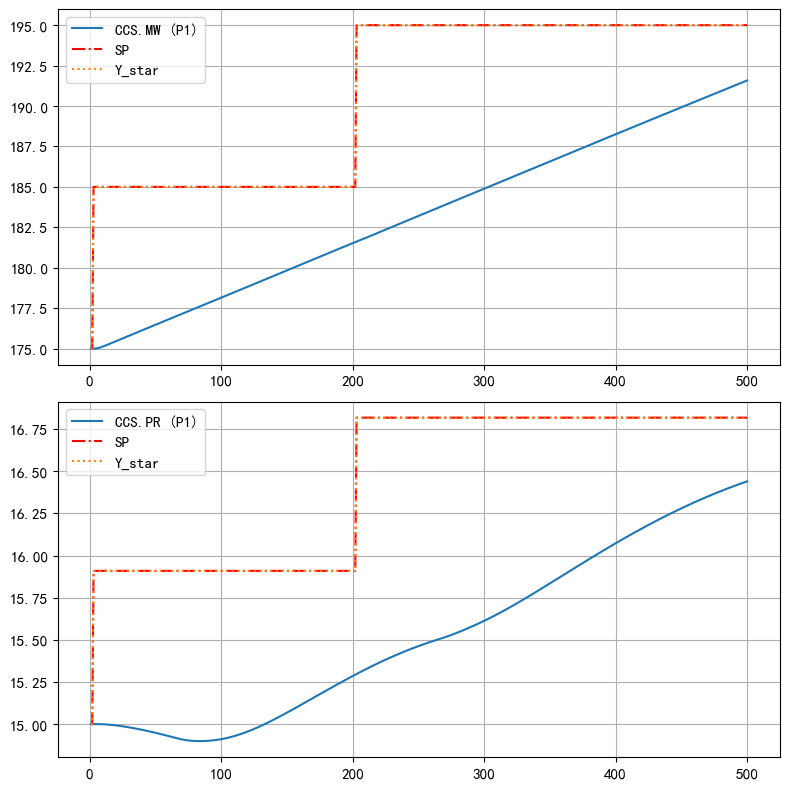

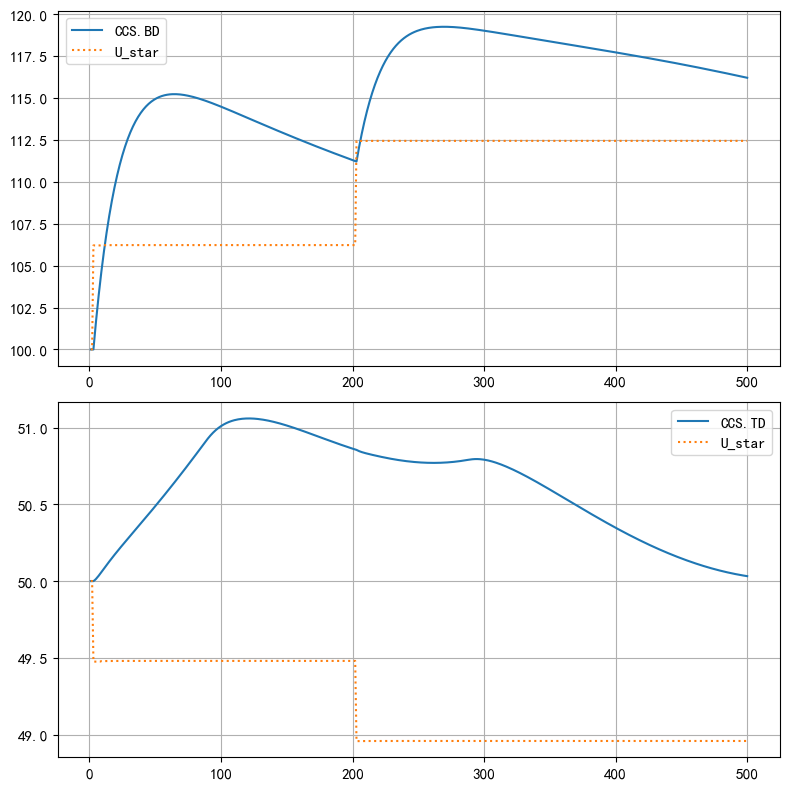

In [4]:

# 被控对象仿真器
Simulator = CCSSim()

# 定义控制器
mpc1 = ControllerInterface()

# 设置控制器模型
mpc1.SetupModelPy(ccs_plant)

# 设置仿真时长
N = 500

for k in range(0, N):

    input_dict = {}
    # 配置协调设定值
    if 0 < k < 200:
        input_dict.update({'CCS.MW_TARGET': 185,
                                        'CCS.MW_SP_BIAS': 0.0,
                                        'CCS.PR_SP_BIAS': 0.0})
    elif 200 < k < 600:
        input_dict.update({'CCS.MW_TARGET': 195,
                                        'CCS.MW_SP_BIAS': 0.0,
                                        'CCS.PR_SP_BIAS': 0.0})

    # 获取实时数据
    DataDict = Simulator.get_data()

    # 配置MPC
    mpc1.EconomicOptFlag = 0
    mpc1.DistPredSW = 0

    # 配置MPC中的CV参数
    CVx = OutputVariable()
    CVx.ControlStatus = 1
    CVx.ErrorWeight = 1.0
    CVx.IncrementWeight = 0
    CVx.ControlType = 1
    CVx.SetPoint = DataDict['CCS.MW_SP']
    CVx.DistAdaptiveSwt = 1
    CVx.Priority = 1
    CVx.SPFilterAlpha = 2.0
    CVx.SPFilterTau = 0.0
    # CVx.SetNp = 800
    # CVx.IntBlock = 2000
    CVx.FTSPType = 1
    CVx.FTSPRate = DataDict['CCS.MW_SLOPE']
    CVx.FTSPEnd = DataDict['CCS.MW_TARGET']
    CVx.FTSPBias = DataDict['CCS.MW_SP_BIAS']
    CVx.FTSPHzn = 800
    mpc1.ModifyOutputVariablePy('CCS.MW', CVx)

    CVx = OutputVariable()
    CVx.ControlStatus = 1
    CVx.ErrorWeight = 1.0
    CVx.IncrementWeight = 0
    CVx.ControlType = 1
    CVx.SetPoint = DataDict['CCS.PR_SP']
    CVx.DistAdaptiveSwt = 1
    CVx.Priority = 1
    CVx.FTSPType = 2
    CVx.FTSPRate = DataDict['CCS.MW_SLOPE']
    CVx.FTSPNum = DataDict['CCS.MW_SP']
    CVx.FTSPEnd = DataDict['CCS.MW_TARGET']
    CVx.FTSPTau = 1.0
    CVx.FTSPXY = '0,15#175,15#230,20#300,23.5#350,24.2#1000,24.2'
    CVx.FTSPBias = DataDict['CCS.PR_SP_BIAS']
    CVx.FTSPHzn = 800
    mpc1.ModifyOutputVariablePy('CCS.PR', CVx)

    # 配置MPC中的MV参数
    MVx = InputVariable()
    MVx.ControlStatus = 1
    MVx.IncrementWeight = 2.0
    MVx.HiLimit = 300
    MVx.LoLimit = 0
    MVx.IntBlock = 30
    mpc1.ModifyInputVariablePy('CCS.BD', MVx)

    # 更新MV参数
    MVx = InputVariable()
    MVx.ControlStatus = 1
    MVx.IncrementWeight = 5.0
    MVx.HiLimit = 100
    MVx.LoLimit = 0
    MVx.IntBlock = 50
    mpc1.ModifyInputVariablePy('CCS.TD', MVx)

    # 单步调用mpc得到MV动作
    MV_action_dict = mpc1.ControllerCalculationPy(DataDict)
    
    input_dict.update(MV_action_dict)
    
    # 更新仿真器数据，并调用单步计算(以及DV处理)
    Simulator.run(input_dict)
    # Simulator.one_sample_simulation()

# 仿真结果绘图
mpcplot.ShowCurrentParam(mpc1)
mpcplot.PlotControllerData(mpc1)

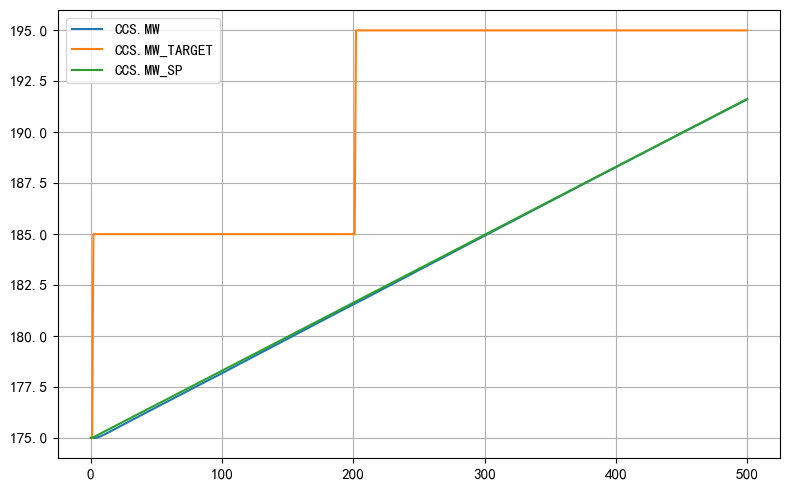

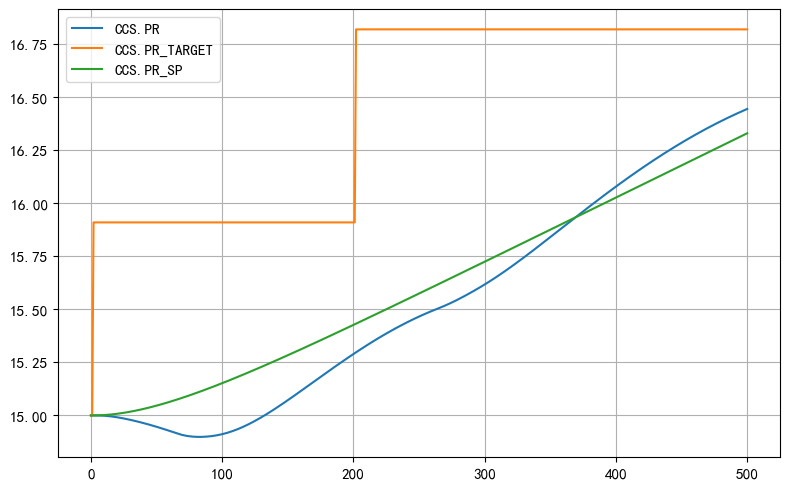

In [4]:
# 利用仿真器绘图
Simulator.plot_record_data_in_one_figure(taglist=['CCS.MW','CCS.MW_TARGET','CCS.MW_SP'])
Simulator.plot_record_data_in_one_figure(taglist=['CCS.PR','CCS.PR_TARGET','CCS.PR_SP'])
